<a href="https://colab.research.google.com/github/apoorvds99/customer-churn-recommendation-system/blob/main/Customer_Churn_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Churn Risk Prediction and Segmentation

## Problem Statement
Customer churn directly impacts revenue and long-term business sustainability.
The objective of this project is to build a machine learning model that predicts customer churn probability
using demographic, behavioral, and billing data, and to derive actionable insights for targeted retention strategies.

## Objectives
- Identify customers at high risk of churn
- Understand key drivers contributing to churn
- Evaluate classification models using appropriate metrics for imbalanced data
- Provide business-focused recommendations for reducing churn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("/content/Customer-Churn.csv")

In [ ]:
df.shape

(7043, 21)

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Dataset Overview
The dataset contains customer-level information including demographics, service subscriptions,
billing details, and payment methods. Each record represents a unique customer along with
their churn status.


## Target Variable Analysis: Churn


In [ ]:
df["Churn"].value_counts()

,count
Churn,
No,5174
Yes,1869


In [ ]:
df['Churn'].value_counts(normalize=True) * 100


,proportion
Churn,
No,73.463013
Yes,26.536987


### Key Observations
 The target variable is imbalanced, with churned customers forming a minority class.

## EDA: Key Drivers of Customer Churn


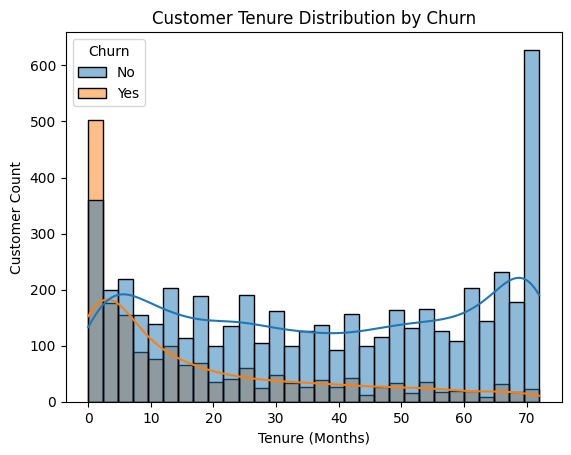

In [ ]:
sns.histplot(data=df, x='tenure', hue='Churn', bins=30, kde=True)
plt.title("Customer Tenure Distribution by Churn")
plt.xlabel("Tenure (Months)")
plt.ylabel("Customer Count")
plt.show()

 Customers in the early stages of their subscription show significantly higher churn rates.


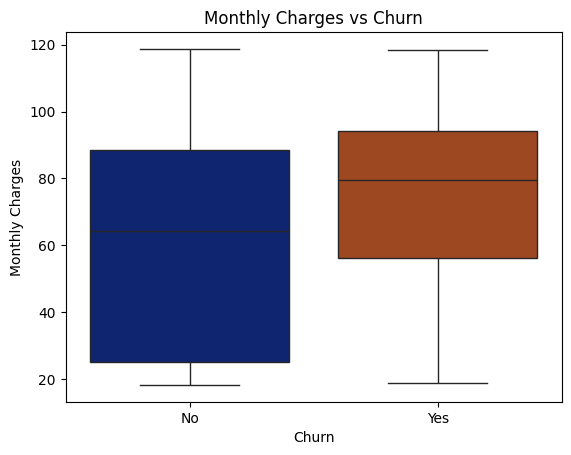

In [ ]:
sns.boxplot(data=df, x="Churn", y="MonthlyCharges", palette="dark")
plt.title("Monthly Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.show()

Higher monthly charges are associated with increased churn risk.


In [ ]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

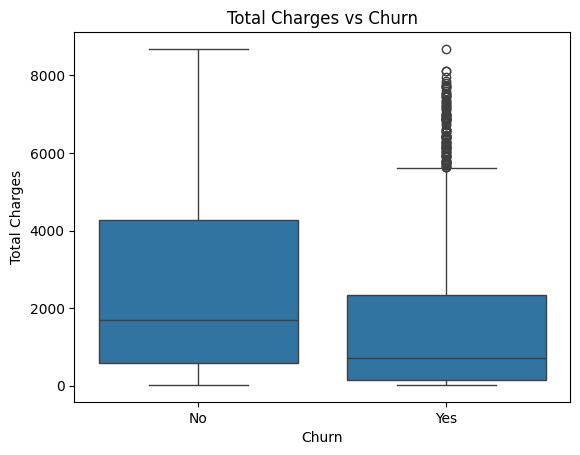

In [ ]:
sns.boxplot(data=df, x="Churn", y="TotalCharges")
plt.title("Total Charges vs Churn")
plt.xlabel("Churn")
plt.ylabel("Total Charges")
plt.show()

Customers with lower total charges are more likely to churn.

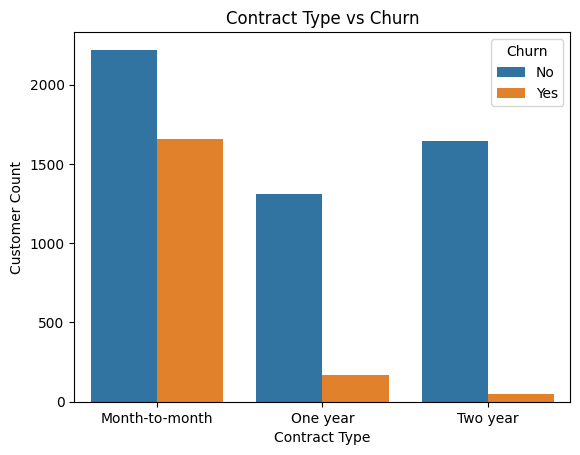

In [ ]:
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Contract Type vs Churn")
plt.xlabel("Contract Type")
plt.ylabel("Customer Count")
plt.show()

Customers on month-to-month contracts exhibit significantly higher churn, while long-term contracts act as a strong retention mechanism.

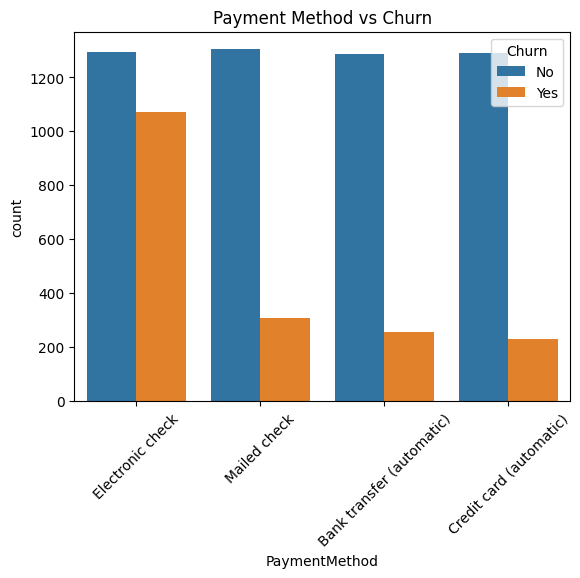

In [ ]:
sns.countplot(data=df, x='PaymentMethod', hue='Churn')
plt.xticks(rotation=45)
plt.title("Payment Method vs Churn")
plt.show()


Customers using electronic check payment methods show higher churn rates, and those with automatic payment method shows significantly lower churn rates.


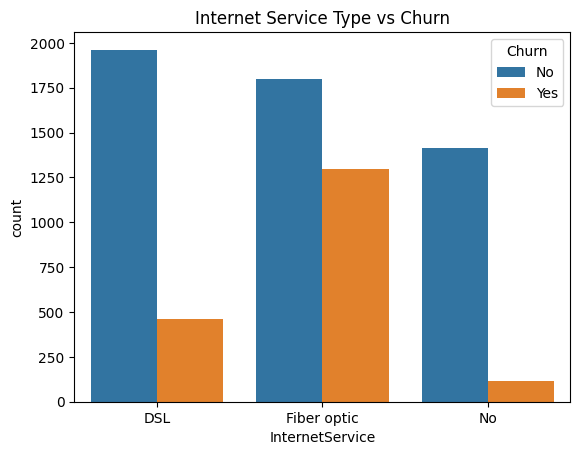

In [ ]:
sns.countplot(data=df, x='InternetService', hue='Churn')
plt.title("Internet Service Type vs Churn")
plt.show()

Fiber optic customers show higher churn compared to DSL users and least churn is with people who do not use Internet Service.

## Key Insights
- Churn is highest among low-tenure customers.
- Higher monthly charges increase churn likelihood.
- Month-to-month contracts are the strongest churn drivers.
- Payment method influences churn behavior, with electronic checks showing higher churn.
- Long-term customers exhibit significantly lower churn risk.


## Data Preprocessing and Feature Engineering


In [ ]:
#Removing CustomerID as it will not contribute to modeling.

df = df.drop('customerID', axis=1)


In [ ]:
df.isnull().sum()

,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


In [ ]:
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

Missing values in TotalCharges were filled using the median.

In [ ]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [ ]:
X= df.drop("Churn", axis=1)
y= df["Churn"]

In [ ]:
X = pd.get_dummies(X, drop_first=True).astype(int)


Categorical variables were one-hot encoded. To ensure compatibility with linear and tree-based models.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [ ]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Feature scaling was applied using StandardScaler, fitted only on the training data to prevent data leakage.


## Model Training and Evaluation


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

lr.fit(X_train, y_train)

y_pred_lr= lr.predict(X_test)
y_prob_lr= lr.predict_proba(X_test)[:,1]


print("Logistic Regression Results")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

Logistic Regression Results
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8416156449404532


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt.fit(X_train, y_train)

y_pred_dt= dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:,1]

print("Decision Tree Results")
print(classification_report(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))

Decision Tree Results
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.49      0.49       374

    accuracy                           0.73      1409
   macro avg       0.65      0.65      0.65      1409
weighted avg       0.73      0.73      0.73      1409

ROC-AUC: 0.6504533829342013


### Model Observations
- Logistic Regression provides stable and interpretable baseline performance.
- Decision Tree captures non-linear patterns but shows signs of overfitting.
- These baseline models establish a reference point for further optimization.

## Feature Importance


In [ ]:
feature_importance_lr = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lr.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

feature_importance_lr.head()

,Feature,Coefficient
10,InternetService_Fiber optic,1.149944
3,TotalCharges,0.482978
28,PaymentMethod_Electronic check,0.403512
23,StreamingMovies_Yes,0.395261
21,StreamingTV_Yes,0.368399


Key churn drivers identified by Logistic Regression include contract type, tenure, and monthly charges.
Long-term contracts and higher tenure reduce churn risk, while higher total charges increase churn likelihood.


In [ ]:
feature_importance_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance_dt.head(10)

,Feature,Importance
3,TotalCharges,0.204485
25,Contract_Two year,0.153649
2,MonthlyCharges,0.115868
1,tenure,0.115548
24,Contract_One year,0.096091
10,InternetService_Fiber optic,0.043443
4,gender_Male,0.030191
6,Dependents_Yes,0.022490
28,PaymentMethod_Electronic check,0.021504
23,StreamingMovies_Yes,0.021359


Decision Tree feature importance highlights tenure, contract duration, and monthly charges as the most influential predictors, aligning with insights observed during exploratory data analysis.


### Feature Importance Validation
The most influential features identified by the models align with business intuition and EDA findings,
indicating that the models are learning meaningful patterns rather than noise.


## Hyperparameter Tuning and Model Optimization


In [ ]:
from sklearn.model_selection import GridSearchCV

lr_params= {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver":["lbfgs"]
}

lr_grid = GridSearchCV( estimator=LogisticRegression(
    max_iter=1000, class_weight="balanced", random_state=42
), param_grid=lr_params, scoring="roc_auc", cv=5, n_jobs=-1)

lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs']},
             scoring='roc_auc')

In [ ]:
best_lr = lr_grid.best_estimator_

y_pred_lr_tuned = best_lr.predict(X_test)
y_prob_lr_tuned = best_lr.predict_proba(X_test)[:,1]

print("Tuned Logistic Regression")
print(classification_report(y_test, y_pred_lr_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr_tuned))

Tuned Logistic Regression
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409

ROC-AUC: 0.8406985455578806


Hyperparameter tuning marginally improved Logistic Regression performance, indicating that the baseline model was already well-optimized.


In [ ]:
dt_params = {
    "max_depth": [3,5,7,10, None],
    "min_samples_split": [2,5,10],
    "min_samples_leaf":[1,5,10]
}

dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(
    class_weight="balanced", random_state= 42
), param_grid= dt_params, scoring= "roc_auc", cv=5, n_jobs=-1)

dt_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10, None],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 5, 10]},
             scoring='roc_auc')

In [ ]:
best_dt = dt_grid.best_estimator_

y_pred_dt_tuned = best_dt.predict(X_test)
y_prob_dt_tuned = best_dt.predict_proba(X_test)[:, 1]

print("Tuned Decision Tree")
print(classification_report(y_test, y_pred_dt_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt_tuned))

Tuned Decision Tree
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.50      0.81      0.62       374

    accuracy                           0.73      1409
   macro avg       0.70      0.76      0.71      1409
weighted avg       0.80      0.73      0.75      1409

ROC-AUC: 0.830482575111731


Hyperparameter tuning significantly reduced overfitting in the Decision Tree model and improved its generalization performance.


### Model Performance Comparison
- Tuned Logistic Regression showed marginal improvement over baseline.
- Tuned Decision Tree demonstrated better generalization compared to its baseline version.
- Logistic Regression remains the most stable and interpretable model for churn prediction.


## Handling Class Imbalance Using SMOTE


In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
X_train_smote_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [ ]:
lr_smote = LogisticRegression( max_iter=1000, random_state=42)
lr_smote.fit(X_train_smote_scaled, y_train_smote)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred_lr_smote = lr_smote.predict(X_test_scaled)
y_prob_lr_smote = lr_smote.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression with SMOTE")
print(classification_report(y_test, y_pred_lr_smote))
print("RO-AUC:", roc_auc_score(y_test, y_prob_lr_smote))

Logistic Regression with SMOTE
              precision    recall  f1-score   support

           0       0.89      0.78      0.83      1035
           1       0.54      0.73      0.62       374

    accuracy                           0.76      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.76      0.77      1409

RO-AUC: 0.8353509519749929


In [ ]:
dt_smote = DecisionTreeClassifier( random_state=42)
dt_smote.fit(X_train_smote, y_train_smote)


DecisionTreeClassifier(random_state=42)

In [ ]:
y_pred_dt_smote = dt_smote.predict(X_test)
y_prob_dt_smote = dt_smote.predict_proba(X_test)[:,1]


print("Decision Tree with SMOTE")
print(classification_report(y_test, y_pred_dt_smote))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt_smote))

Decision Tree with SMOTE
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      1035
           1       0.49      0.59      0.53       374

    accuracy                           0.73      1409
   macro avg       0.66      0.68      0.67      1409
weighted avg       0.74      0.73      0.73      1409

ROC-AUC: 0.6888036373969878


### SMOTE Experiment Observations
- SMOTE improved recall for the churn class by increasing minority class representation.
- Logistic Regression didn't benefited from SMOTE, while Decision Tree showed limited improvement as compared to baseline model.
- SMOTE was evaluated as an experimental technique.

## Final Model Selection and Threshold Optimization



The tuned model was selected as the final model based on higher ROC-AUC and better recall for churn class, which is critical for retention strategies.

In [ ]:
y_prob_final = best_lr.predict_proba(X_test_scaled)[:, 1]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.2, 0.6, 0.05)

for t in thresholds:
  y_pred_thresh= (y_prob_final >= t).astype(int)
  print(f"Threshold: {t:.2f} | "
          f"Recall: {recall_score(y_test, y_pred_thresh):.2f} | "
          f"Precision: {precision_score(y_test, y_pred_thresh):.2f} | "
          f"F1: {f1_score(y_test, y_pred_thresh):.2f}")

Threshold: 0.20 | Recall: 0.78 | Precision: 0.44 | F1: 0.56
Threshold: 0.25 | Recall: 0.74 | Precision: 0.45 | F1: 0.56
Threshold: 0.30 | Recall: 0.71 | Precision: 0.46 | F1: 0.56
Threshold: 0.35 | Recall: 0.69 | Precision: 0.47 | F1: 0.56
Threshold: 0.40 | Recall: 0.68 | Precision: 0.47 | F1: 0.56
Threshold: 0.45 | Recall: 0.67 | Precision: 0.48 | F1: 0.56
Threshold: 0.50 | Recall: 0.65 | Precision: 0.49 | F1: 0.56
Threshold: 0.55 | Recall: 0.64 | Precision: 0.49 | F1: 0.56


A lower decision threshold was selected to prioritize recall, ensuring that a higher proportion of churn-prone customers are identified for proactive retention efforts.


In [ ]:
final_threshold = 0.35

y_pred_final = (y_prob_final >= final_threshold).astype(int)

print("Final Model Performance")
print(classification_report(y_test, y_pred_final))

Final Model Performance
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      1035
           1       0.47      0.69      0.56       374

    accuracy                           0.71      1409
   macro avg       0.67      0.70      0.67      1409
weighted avg       0.76      0.71      0.72      1409



# Retention Strategy Recommendation Engine

In this section, I will build a **Retention Strategy Recommendation Engine** that:

1. Uses churn probability from the trained model
2. Defines multiple retention actions
3. Estimates expected profit for each action
4. Recommends the best action per customer

In [ ]:
y_prob = best_lr.predict_proba(X_test)[:, 1]

In [ ]:
results_df = X_test.copy()
results_df["Churn_Probability"] = y_prob

In [ ]:
results_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Probability
437,0,1.608483,1.643781,2.707736,1,1,1,1,0,1,...,1,0,1,0,1,1,1,0,0,0.117980
2280,1,-0.996684,1.179200,-0.611541,0,0,0,1,0,1,...,1,0,1,0,0,1,1,0,0,0.849298
2235,0,0.346606,0.449143,0.399610,0,1,1,1,0,1,...,1,0,0,1,0,1,1,0,0,0.131833
4460,0,-0.589626,0.449143,-0.365668,1,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0.671182
3761,0,1.608483,0.581881,1.588578,0,1,0,1,0,1,...,1,0,1,0,1,1,1,0,0,0.064547


###  Defining Retention Actions

Three retention strategies:


- **Discount** → Cost: $20, Success rate: 60%

- **Call** → Cost: $5, Success rate: 40%

- **Upgrade** → Cost: $50, Success rate: 75%     

These values represent typical business assumptions.


In [ ]:
actions = {
    "Discount": {"cost": 20, "success_rate": 0.60},
    "Call": {"cost": 5, "success_rate": 0.40},
    "Upgrade": {"cost": 50, "success_rate": 0.75}
}

actions

{'Discount': {'cost': 20, 'success_rate': 0.6},
 'Call': {'cost': 5, 'success_rate': 0.4},
 'Upgrade': {'cost': 50, 'success_rate': 0.75}}

### Estimate Customer Value


This assumes the company retains the customer for one more year.


In [ ]:
original_df = df.copy()

X = original_df.drop('Churn', axis=1)
y = original_df['Churn']

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
results_df['Customer_Value'] = X_test_orig['MonthlyCharges'].values * 12

results_df[['Churn_Probability', 'Customer_Value']].head()


,Churn_Probability,Customer_Value
437,0.117980,1368.6
2280,0.849298,1201.8
2235,0.131833,940.2
4460,0.671182,938.4
3761,0.064547,991.8


In [ ]:
#Recommendation engine

def recommend_action(row):
    churn_prob = row['Churn_Probability']
    customer_value = row['Customer_Value']

    best_action = "No Action"
    best_profit = 0

    for action, details in actions.items():
        cost = details['cost']
        success = details['success_rate']

        expected_profit = (churn_prob * success * customer_value) - cost

        if expected_profit > best_profit:
            best_profit = expected_profit
            best_action = action

    return pd.Series([best_action, best_profit])

In [ ]:
results_df[['Recommended_Action', 'Expected_Profit']] = results_df.apply(
    recommend_action, axis=1
)

In [ ]:
results_df[['Churn_Probability', 'Customer_Value', 'Recommended_Action', 'Expected_Profit']].head()

,Churn_Probability,Customer_Value,Recommended_Action,Expected_Profit
437,0.117980,1368.6,Discount,76.880115
2280,0.849298,1201.8,Upgrade,715.514526
2235,0.131833,940.2,Discount,54.369913
4460,0.671182,938.4,Upgrade,422.377950
3761,0.064547,991.8,Call,20.606966


This section shows churn probability, estimated customer value, and the optimal retention action for each customer based on expected profit.


In [ ]:
#Final recommendation table

final_output = results_df[
    ['Churn_Probability', 'Customer_Value', 'Recommended_Action', 'Expected_Profit']
]

final_output.head(10)


,Churn_Probability,Customer_Value,Recommended_Action,Expected_Profit
437,0.117980,1368.6,Discount,76.880115
2280,0.849298,1201.8,Upgrade,715.514526
2235,0.131833,940.2,Discount,54.369913
4460,0.671182,938.4,Upgrade,422.377950
3761,0.064547,991.8,Call,20.606966
5748,0.809095,1198.2,Upgrade,677.093166
3568,0.698699,1189.8,Upgrade,573.484014
2976,0.291150,289.2,Discount,30.520317
5928,0.008783,237.0,No Action,0.000000
1639,0.646106,540.6,Upgrade,211.963519


## Business Insights

## Key Business Insights

- Customers with higher monthly charges and shorter tenure show higher churn probability.
- Month-to-month contract customers are the most likely to churn.
- Customers using fewer additional services are more prone to churn.
- High churn probability customers represent the biggest revenue risk.

### Model Usage in Practice

- Predict churn probability for each customer.
- Estimate customer annual value.
- Simulate multiple retention strategies.
- Recommend the action with the highest expected profit.


## Conclusion
This project demonstrates an end-to-end churn prediction workflow, from exploratory analysis and feature engineering
to model evaluation and business-driven decision-making. The final model balances interpretability, performance,
and practical applicability for real-world churn management. The model was enhanced with a retention recommendation engine. The system evaluates multiple retention strategies using cost and success assumptions. For each customer, the most profitable action is recommended.


## For Streamlit Deployment

In [ ]:
with open("model.pkl", "wb") as f:
  pickle.dump(best_lr, f)

with open("scaler.pkl", "wb") as f:
  pickle.dump(scaler, f)

with open("columns.pkl", "wb") as f:
  pickle.dump(X_train.columns.tolist(), f)